## Практическое задание к уроку 4 по теме "CNN Свертки".

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. \*Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.
4. Сравните результаты обучения на эквивалентном числе эпох.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms, datasets, models

In [2]:
PATH = './data/'
RANDOM_STATE = 29

Напишем функцию для загрузки данных для исключения повторения кода:

In [3]:
def load_data(transform_train=transforms.ToTensor(), transform_test=transforms.ToTensor(), 
              download=True, verbose=True):
    
    train_dataset = datasets.CIFAR100(root=PATH,
                                      transform=transform_train,
                                      download=download)

    test_dataset = datasets.CIFAR100(root=PATH,
                                     train=False,
                                     transform=transform_test,
                                     download=download)
    
    if verbose:
        print(f'Размер тренировочного датасета:\t{len(train_dataset)}')
        print(f'Размер тестового датасета:\t{len(test_dataset)}')
    
    torch.random.manual_seed(RANDOM_STATE)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=128,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=128,
                                              shuffle=False)
    
    return train_loader, test_loader

Напишем трансформер для аугментации. Вспомогательный трансформер нужен, т.к.  
применение ToTensor() к тензору вызывает ошибку, когда мы используем ещё один  
трансформер для подготовки данных для ResNet.

In [4]:
aug_transformers_ = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

aug_transformers = transforms.Compose([
    aug_transformers_,
    transforms.ToTensor()
])

## Наша модель

Загрузим данные. Для нашей модели сразу будем применять аугментации:

In [5]:
train_loader, test_loader = load_data(transform_train=aug_transformers)

Files already downloaded and verified
Files already downloaded and verified
Размер тренировочного датасета:	50000
Размер тестового датасета:	10000


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
image_size = next(iter(train_loader))[0][0].shape
image_size

torch.Size([3, 32, 32])

Напишем нашу сеть, track_running_stats в батч-нормализации выключим,  
т.к. это даёт лучшую точность:

In [10]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        torch.random.manual_seed(RANDOM_STATE)
        
        self.conv1 = nn.Conv2d(image_size[0], 32, 3, padding=1) 
        self.maxpool = nn.MaxPool2d(2) 
        self.bn1 = nn.BatchNorm2d(32, track_running_stats=False)
        self.dp = nn.Dropout(0.25)
        self.dp2d = nn.Dropout2d(0.25)
    
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(64, track_running_stats=False)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) 
        self.bn3 = nn.BatchNorm2d(128, track_running_stats=False)
    
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*4*4, 512)
        self.bn4 = nn.BatchNorm1d(512, track_running_stats=False)
        
        self.fc2 = nn.Linear(512, 100)
        
    def forward(self, x):
        
        # Свёрточные слои
        x = self.conv1(x) # 3x32x32 -> 32x32x32
        x = self.maxpool(x) # 32x32x32 -> 32x16x16
        # x = self.dp2d(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x) # 32x16x16 -> 64x16x16
        x = self.maxpool(x) # 64x16x16 -> 64x8x8
        x = self.dp2d(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.conv3(x) # 64x8x8 -> 128x8x8
        x = self.maxpool(x) # 128x8x8 -> 128x4x4
        # x = self.dp2d(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Полносвязные слои
        x = self.flatten(x) # 128x4x4 -> 128*4*4
        x = self.fc1(x)
        x = self.dp(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x = F.softmax(x, dim=1)
        return x

In [11]:
summary(MyNet().to(device), input_size=image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
       BatchNorm2d-3           [-1, 32, 16, 16]              64
            Conv2d-4           [-1, 64, 16, 16]          18,496
         MaxPool2d-5             [-1, 64, 8, 8]               0
         Dropout2d-6             [-1, 64, 8, 8]               0
       BatchNorm2d-7             [-1, 64, 8, 8]             128
            Conv2d-8            [-1, 128, 8, 8]          73,856
         MaxPool2d-9            [-1, 128, 4, 4]               0
      BatchNorm2d-10            [-1, 128, 4, 4]             256
          Flatten-11                 [-1, 2048]               0
           Linear-12                  [-1, 512]       1,049,088
          Dropout-13                  [-1, 512]               0
      BatchNorm1d-14                  [

Общая функция для обучения моделей:

In [12]:
def train_nn(net, train_loader, test_loader, lr=1e-3, epochs=5, verbose=True, parameters=None):

    torch.backends.cudnn.deterministic = True
    criterion = nn.CrossEntropyLoss()
    if parameters is None:
        parameters = net.parameters()
    optimizer = torch.optim.Adam(parameters, lr=lr)
    
    metrics_train_global = np.array([])
    metrics_test_global = np.array([])

    for epoch in range(epochs):
        start_time = time.time()
        metrics_train = np.array([])
        metrics_test = np.array([])
        losses_train = np.array([])
        losses_test = np.array([])

        for i, data in enumerate(train_loader):
            net.train()
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses_train = np.append(losses_train, loss.item())
            net.eval()
            metrics_train = np.append(metrics_train, (labels == outputs.argmax(axis=1)).sum().cpu() / len(labels))
        
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                losses_test = np.append(losses_test, loss.item())
                metrics_test = np.append(metrics_test, (labels == outputs.argmax(axis=1)).sum().cpu() / len(labels))    
        
        if verbose:
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Train loss: {losses_train.mean():.4f}. '\
                  f'Test loss: {losses_test.mean():.4f}. '\
                  f'Train accuracy: {metrics_train.mean():.4f}. '\
                  f'Test accuracy: {metrics_test.mean():.4f}. '
                  f'Time: {int(time.time() - start_time)} s')
        
        metrics_train_global = np.append(metrics_train_global, metrics_train.mean())
        metrics_test_global = np.append(metrics_test_global, metrics_test.mean())
    print('Training is finished!')
    return metrics_train_global, metrics_test_global

Обучаем модель:

In [13]:
mynet = MyNet().to(device)
mynet_train, mynet_test = train_nn(mynet, train_loader, test_loader, epochs=20)

Epoch [1/20]. Train loss: 3.4855. Test loss: 2.7247. Train accuracy: 0.1812. Test accuracy: 0.3135. Time: 52 s
Epoch [2/20]. Train loss: 2.6796. Test loss: 2.2979. Train accuracy: 0.3264. Test accuracy: 0.4032. Time: 50 s
Epoch [3/20]. Train loss: 2.3519. Test loss: 2.1092. Train accuracy: 0.3921. Test accuracy: 0.4491. Time: 50 s
Epoch [4/20]. Train loss: 2.1503. Test loss: 2.0233. Train accuracy: 0.4369. Test accuracy: 0.4683. Time: 50 s
Epoch [5/20]. Train loss: 1.9956. Test loss: 1.9217. Train accuracy: 0.4717. Test accuracy: 0.4925. Time: 50 s
Epoch [6/20]. Train loss: 1.8754. Test loss: 1.8797. Train accuracy: 0.4965. Test accuracy: 0.5069. Time: 50 s
Epoch [7/20]. Train loss: 1.7858. Test loss: 1.8542. Train accuracy: 0.5157. Test accuracy: 0.5164. Time: 50 s
Epoch [8/20]. Train loss: 1.6904. Test loss: 1.8482. Train accuracy: 0.5389. Test accuracy: 0.5177. Time: 47 s
Epoch [9/20]. Train loss: 1.6173. Test loss: 1.8217. Train accuracy: 0.5564. Test accuracy: 0.5224. Time: 50 s
E

## ResNet50

Напишем трансформеры для этой модели:

In [14]:
resnet_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [15]:
resnet_aug_transformer = transforms.Compose([
    aug_transformers_,
    resnet_transformer
])

Обернём все этапы в функцию, чтобы потом не дублировать код при  
обучении ResNet с аугментацией:

In [16]:
def train_resnet(transformer_train, epochs=5, verbose=1):
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    for param in resnet50.parameters():
        param.requires_grad = False
        
    resnet_train_loader, resnet_test_loader = load_data(transform_train=transformer_train, 
                                                        transform_test=resnet_transformer,
                                                        download=False, verbose=False)
    
    torch.random.manual_seed(RANDOM_STATE)
    resnet50.fc = nn.Linear(2048, 100)

    params_to_update = []
    for param in resnet50.parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    
    resnet50 = resnet50.to(device)
    resnet_train, resnet_test = train_nn(resnet50, resnet_train_loader, resnet_test_loader, 
                                         epochs=epochs, verbose=verbose, parameters=params_to_update)
    return resnet50, resnet_train, resnet_test

Обучим ResNet без аугментации:

In [17]:
resnet50, resnet_train, resnet_test = train_resnet(resnet_transformer, epochs=20)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\leva_/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:28<00:00, 3.59MB/s]


Epoch [1/20]. Train loss: 2.5938. Test loss: 1.9313. Train accuracy: 0.4167. Test accuracy: 0.5261. Time: 354 s
Epoch [2/20]. Train loss: 1.6756. Test loss: 1.6810. Train accuracy: 0.5767. Test accuracy: 0.5638. Time: 352 s
Epoch [3/20]. Train loss: 1.4176. Test loss: 1.5881. Train accuracy: 0.6306. Test accuracy: 0.5780. Time: 351 s
Epoch [4/20]. Train loss: 1.2683. Test loss: 1.5233. Train accuracy: 0.6650. Test accuracy: 0.5887. Time: 351 s
Epoch [5/20]. Train loss: 1.1544. Test loss: 1.4842. Train accuracy: 0.6945. Test accuracy: 0.6003. Time: 351 s
Epoch [6/20]. Train loss: 1.0655. Test loss: 1.4692. Train accuracy: 0.7170. Test accuracy: 0.6015. Time: 351 s
Epoch [7/20]. Train loss: 0.9915. Test loss: 1.4597. Train accuracy: 0.7380. Test accuracy: 0.6060. Time: 351 s
Epoch [8/20]. Train loss: 0.9309. Test loss: 1.4596. Train accuracy: 0.7528. Test accuracy: 0.6039. Time: 351 s
Epoch [9/20]. Train loss: 0.8767. Test loss: 1.4457. Train accuracy: 0.7688. Test accuracy: 0.6055. Time

Обучим ResNet с аугментацией:

In [18]:
resnet50_aug, resnet_aug_train, resnet_aug_test = train_resnet(resnet_aug_transformer, epochs=20)

Epoch [1/20]. Train loss: 2.8360. Test loss: 2.0525. Train accuracy: 0.3617. Test accuracy: 0.5052. Time: 379 s
Epoch [2/20]. Train loss: 2.0108. Test loss: 1.7701. Train accuracy: 0.4950. Test accuracy: 0.5489. Time: 379 s
Epoch [3/20]. Train loss: 1.7872. Test loss: 1.6509. Train accuracy: 0.5372. Test accuracy: 0.5719. Time: 379 s
Epoch [4/20]. Train loss: 1.6630. Test loss: 1.5670. Train accuracy: 0.5614. Test accuracy: 0.5857. Time: 379 s
Epoch [5/20]. Train loss: 1.5797. Test loss: 1.5357. Train accuracy: 0.5794. Test accuracy: 0.5928. Time: 379 s
Epoch [6/20]. Train loss: 1.5218. Test loss: 1.4970. Train accuracy: 0.5930. Test accuracy: 0.5981. Time: 379 s
Epoch [7/20]. Train loss: 1.4781. Test loss: 1.4746. Train accuracy: 0.6003. Test accuracy: 0.6028. Time: 380 s
Epoch [8/20]. Train loss: 1.4290. Test loss: 1.4803. Train accuracy: 0.6102. Test accuracy: 0.6001. Time: 379 s
Epoch [9/20]. Train loss: 1.3971. Test loss: 1.4508. Train accuracy: 0.6187. Test accuracy: 0.6060. Time

Построим графики метрики:

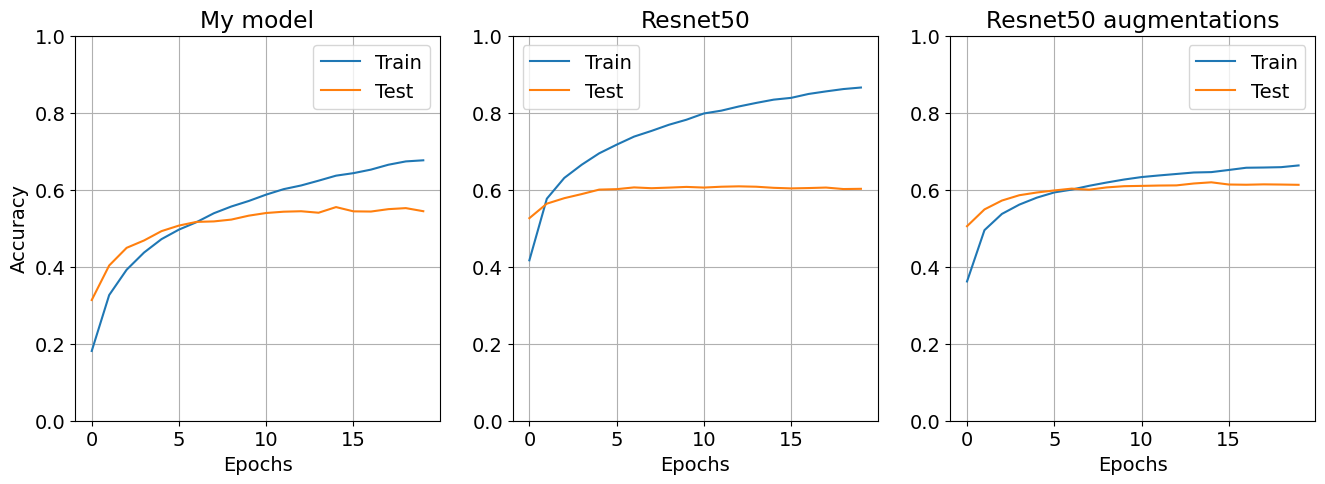

In [21]:
plt.figure(figsize=(16, 5))
plt.rcParams.update({'font.size': 14})

plt.subplot(1, 3, 1)
plt.plot(range(len(mynet_train)), mynet_train, label='Train')
plt.plot(range(len(mynet_test)), mynet_test, label='Test')
plt.title('My model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(len(resnet_train)), resnet_train, label='Train')
plt.plot(range(len(resnet_test)), resnet_test, label='Test')
plt.title('Resnet50')
plt.xlabel('Epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(len(resnet_aug_train)), resnet_aug_train, label='Train')
plt.plot(range(len(resnet_aug_test)), resnet_aug_test, label='Test')
plt.title('Resnet50 augmentations')
plt.xlabel('Epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.show()

Теперь сравним точность предсказания моделей на тестовых данных между собой:

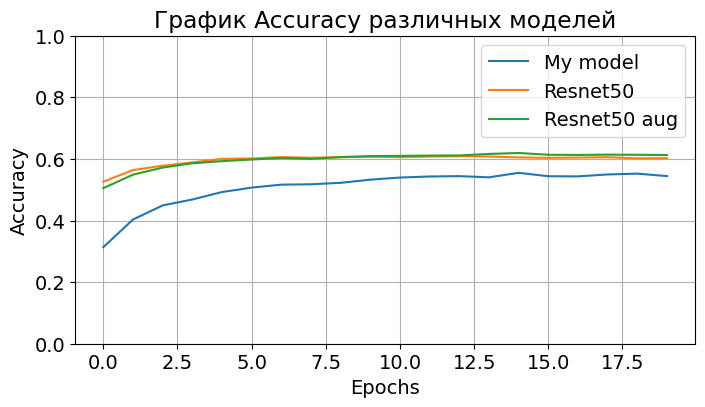

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(mynet_test)), mynet_test, label='My model')
plt.plot(range(len(resnet_test)), resnet_test, label='Resnet50')
plt.plot(range(len(resnet_aug_test)), resnet_aug_test, label='Resnet50 aug')
plt.title('График Accuracy различных моделей')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

ResNet50 с аугментацией показал чуть более высокую точность, чем аналогичная модель без аугментации.